In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [11]:
with open('tg.xvg','r') as f:
    lines = f.readlines()
    time = []
    temp = []
    dens = []
    for line in lines:
        if line.startswith('#')==False and line.startswith('@')==False:
            time.append(float(line.split()[0]))
            temp.append(float(line.split()[1]))
            dens.append(float(line.split()[2]))

time = np.array(time)
temp = np.array(temp)
dens = np.array(dens)

time_ns = time/1000

start_time = 0.0
interval = 2.0
skip = 3.0

if time_ns[0] == 0.0:
    start_time = time_ns[3]
    
averaged_data = []

while start_time < time_ns[-1]:
    interval_start = start_time
    interval_end = start_time + interval

    indices = (time_ns >= interval_start) & (time_ns < interval_end)
    
    avg_dens = np.mean(dens[indices]) if np.any(indices) else np.nan
    avg_temp = np.mean(temp[indices]) if np.any(indices) else np.nan
    std_dens = np.std(dens[indices]) if np.any(indices) else np.nan

    averaged_data.append([avg_temp, avg_dens, std_dens])

    start_time += skip

In [17]:
averaged_data = np.array(averaged_data)
temp_range = np.arange(1200, 199, -20)
avg_temp = averaged_data[:, 0] 
avg_dens = averaged_data[:, 1]  

low_temp_mask = avg_temp < 300  # low temp regime
high_temp_mask = avg_temp >= 990  # high temp regime

low_temp_fit = np.polyfit(avg_temp[low_temp_mask], avg_dens[low_temp_mask], 1)  # low temp fit
high_temp_fit = np.polyfit(avg_temp[high_temp_mask], avg_dens[high_temp_mask], 1)  # high temp fit

x_low = np.linspace(min(avg_temp[low_temp_mask]), max(avg_temp[low_temp_mask]), 100) 
x_high = np.linspace(min(avg_temp[high_temp_mask]), max(avg_temp[high_temp_mask]), 100)

x_low_extrapolated = np.linspace(200, 1200, 100)
x_high_extrapolated = np.linspace(200, 1200, 100)

y_low = np.polyval(low_temp_fit, x_low)
y_high = np.polyval(high_temp_fit, x_high)

y_low_extrapolated = np.polyval(low_temp_fit, x_low_extrapolated)
y_high_extrapolated = np.polyval(high_temp_fit, x_high_extrapolated)

# intersection point calculation
m_low, b_low = low_temp_fit  
m_high, b_high = high_temp_fit 
x_intersection = (b_high - b_low) / (m_low - m_high)
y_intersection = np.polyval(low_temp_fit, x_intersection)
print(f"Intersection Point: {x_intersection:.2f} K")

# r^2 prediction for low temp
y_low_pred = np.polyval(low_temp_fit, avg_temp[low_temp_mask])  
ss_res_low = np.sum((avg_dens[low_temp_mask] - y_low_pred) ** 2)  
ss_tot_low = np.sum((avg_dens[low_temp_mask] - np.mean(avg_dens[low_temp_mask])) ** 2) 
r2_low = 1 - (ss_res_low / ss_tot_low)

# r^2 prediction for high temp
y_high_pred = np.polyval(high_temp_fit, avg_temp[high_temp_mask])
ss_res_high = np.sum((avg_dens[high_temp_mask] - y_high_pred) ** 2)
ss_tot_high = np.sum((avg_dens[high_temp_mask] - np.mean(avg_dens[high_temp_mask])) ** 2)
r2_high = 1 - (ss_res_high / ss_tot_high)

Intersection Point: 559.16 K


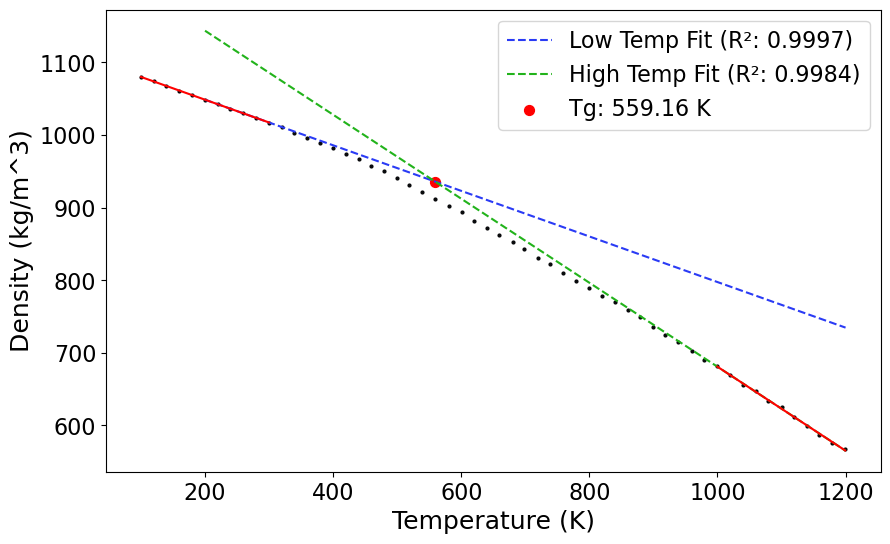

In [21]:
# graph plot
plt.figure(figsize=(10, 6))
plt.plot(avg_temp, avg_dens, marker='o', linestyle='None', color='#07080a', markersize=2) 
plt.xlabel("Temperature (K)", fontsize=18)
plt.ylabel("Average Density (kg/m^3)", fontsize=18)

plt.plot(x_low_extrapolated, y_low_extrapolated, color='#2a3bf5', linestyle='--', markersize=1, label=f"Low Temp Fit (R²: {r2_low:.4f})")
plt.plot(x_high_extrapolated, y_high_extrapolated, color='#22b31b', linestyle='--', markersize=1,  label=f"High Temp Fit (R²: {r2_high:.4f})")

# low and high temp best fit
plt.plot(x_low, y_low, color='red', linestyle='-', markersize=1)
plt.plot(x_high, y_high, color='red', linestyle='-', markersize=1)

# intersection (tg)
plt.scatter(x_intersection, y_intersection, color='red', marker='o', s=50, label=f"Tg: {x_intersection:.2f} K")

plt.xlabel("Temperature (K)", fontsize=18)
plt.ylabel("Density (kg/m^3)", fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()